boardid: starting company ID
companyid: connected company ID

thinking we can get SIC code for each company to be able to do industry to industry matching

In [319]:
import pandas as pd

In [320]:
boardex = pd.read_csv('SMA_boardex.csv')
compustat = pd.read_csv('SMA_compustat.csv')
linking_table = pd.read_csv('boardex_compustat_linkingtable.csv')

In [321]:
print(f'BoardEx Columns: {boardex.columns}')
print(f'Compustat Columns: {compustat.columns}')
print(f'Linking table Columns: {linking_table.columns}')

BoardEx Columns: Index(['associationtype', 'ticker', 'overlapyearstart_int', 'boardname',
       'companyname', 'directorname', 'role', 'associatedrole',
       'conncompanyorgtype', 'boardid', 'companyid', 'directorid', 'roletitle',
       'roleboardposition', 'roleedflag', 'startcompanydatestartrole',
       'overlapyearend_int', 'startcompanydateendrole',
       'conncompanydatestartrole', 'conncompanydateendrole', 'orgtype'],
      dtype='object')
Compustat Columns: Index(['gvkey', 'datadate', 'fyear', 'indfmt', 'consol', 'popsrc', 'datafmt',
       'tic', 'conm', 'curcd', 'at', 'dlc', 'dltt', 'epspx', 'ni', 'costat',
       'mkvalt', 'prcc_f', 'busdesc', 'naics', 'sic'],
      dtype='object')
Linking table Columns: Index(['PERMCO', 'GVKEY', 'companyid'], dtype='object')


### Boardex Cleaning

In [323]:
# Inspect nulls
boardex.isna().sum()

associationtype                   0
ticker                        82921
overlapyearstart_int              0
boardname                         0
companyname                       0
directorname                      0
role                             26
associatedrole                    0
conncompanyorgtype                0
boardid                           0
companyid                         0
directorid                        0
roletitle                        26
roleboardposition                26
roleedflag                   137325
startcompanydatestartrole      7138
overlapyearend_int            93606
startcompanydateendrole        7138
conncompanydatestartrole       7297
conncompanydateendrole         7297
orgtype                           0
dtype: int64

In [324]:
# Drop duplicates - not currently dropping any but maybe worth inspecting further
boardex_unique = boardex.drop_duplicates(subset=['boardname', 'companyname', 'directorname'], keep='first')

In [325]:
# Count the number of unique board names
unique_count = boardex['boardname'].nunique()
print("Number of unique board names:", unique_count)

Number of unique board names: 12335


In [326]:
# Count the number of unique board names
unique_count = boardex['companyname'].nunique()
print("Number of unique company names:", unique_count)

Number of unique company names: 17779


### Compustat Cleaning

In [328]:
# Filter to Just 2022
compustat = compustat[compustat['fyear'] == 2022]

In [329]:
def categorize_sic(sic_code):
    financials = [(6000, 6399), (6700, 6799)]
    oilgas = [(1300, 1399), (2900, 2999), (4600, 4699), (5172, 5172), (4923, 4923)]
    tech = [(3570, 3579), (3660, 3699), (3812, 3812), (3825, 3825), (7370, 7379), (8731, 8734)]

    def in_ranges(code, ranges):
        return any(start <= code <= end for start, end in ranges)

    if in_ranges(sic_code, financials):
        return "Financial"
    elif in_ranges(sic_code, oilgas):
        return "Oil & Gas"
    elif in_ranges(sic_code, tech):
        return "Technology"
    else:
        return "Other"

compustat['industry'] = compustat['sic'].apply(categorize_sic)

In [330]:
compustat['industry'].value_counts()

industry
Financial     6660
Other         5277
Technology    1154
Oil & Gas      350
Name: count, dtype: int64

In [331]:
compustat

,gvkey,datadate,fyear,indfmt,consol,popsrc,datafmt,tic,conm,curcd,...,dltt,epspx,ni,costat,mkvalt,prcc_f,busdesc,naics,sic,industry
5,1004,2023-05-31,2022.0,INDL,C,D,STD,AIR,AAR CORP,USD,...,317.900,2.55,90.200,A,1749.6408,50.110,AAR Corp. provides products and services to co...,423860.0,5080,Other
14,1045,2022-12-31,2022.0,INDL,C,D,STD,AAL,AMERICAN AIRLINES GROUP INC,USD,...,38948.000,0.20,127.000,A,8276.1662,12.720,"American Airlines Group Inc., through its subs...",481111.0,4512,Other
21,1050,2022-12-31,2022.0,INDL,C,D,STD,CECO,CECO ENVIRONMENTAL CORP,USD,...,121.615,0.50,17.417,A,401.5818,11.680,CECO Environmental Corp. provides critical sol...,333413.0,3564,Other
31,1062,2022-11-30,2022.0,FS,C,D,STD,ASA,ASA GOLD AND PRECIOUS METALS,USD,...,0.000,NaN,NaN,A,275.0754,14.260,ASA Gold and Precious Metals Limited is a publ...,523999.0,6799,Financial
32,1062,2022-11-30,2022.0,INDL,C,D,STD,ASA,ASA GOLD AND PRECIOUS METALS,USD,...,0.000,-8.08,-155.940,A,275.0754,14.260,ASA Gold and Precious Metals Limited is a publ...,523999.0,6799,Financial
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85845,353945,2022-12-31,2022.0,INDL,C,D,STD,ACLLY,ACCELLERON INDUSTRIES AG,USD,...,343.767,1.31,122.801,A,NaN,20.693,"Accelleron Industries AG develops, manufacture...",335312.0,3621,Other
85850,355398,2022-12-31,2022.0,INDL,C,D,STD,HDL,SUPER HI INTERNATIONAL HOLDI,USD,...,202.208,-0.64,-41.248,A,NaN,NaN,"Super Hi International Holding Ltd., an invest...",722511.0,5812,Other
85852,356128,2022-12-31,2022.0,INDL,C,D,STD,KSPI,JOINT STOCK COMPANY KASPI KZ,USD,...,349.854,6.60,1264.809,A,NaN,66.000,"Joint Stock Company Kaspi.kz, together with it...",522291.0,6141,Financial
85855,356289,2022-06-30,2022.0,INDL,C,D,STD,SUUN,SOLARBANK CORP,CAD,...,NaN,NaN,NaN,A,NaN,NaN,SolarBank Corporation operates as an independe...,2371.0,1600,Other


In [332]:
industry_df = compustat.groupby('gvkey')['industry'].first().reset_index()
industry_df

,gvkey,industry
0,1004,Other
1,1045,Other
2,1050,Other
3,1062,Financial
4,1075,Other
...,...,...
12408,353945,Other
12409,355398,Other
12410,356128,Financial
12411,356289,Other


In [333]:
linking_table

,PERMCO,GVKEY,companyid
0,5,16671,2917
1,7,1690,2355
2,23,11153,141957
3,24,1402,1764
4,25,1619,2116
...,...,...,...
12040,59717,41896,3698057
12041,59719,40321,3485760
12042,59737,36392,2289835
12043,59745,33195,1985441


### Merge Linking Table

In [335]:
# Merge BoardEx with the linking table on 'companyid'
boardex_linked = boardex.merge(linking_table, on='companyid', how='left')

In [336]:
boardex_linked.rename(columns={'PERMCO':'permco_company','GVKEY':'gvkey_company'}, inplace=True)

In [337]:
boardex_linked

,associationtype,ticker,overlapyearstart_int,boardname,companyname,directorname,role,associatedrole,conncompanyorgtype,boardid,...,roleboardposition,roleedflag,startcompanydatestartrole,overlapyearend_int,startcompanydateendrole,conncompanydatestartrole,conncompanydateendrole,orgtype,permco_company,gvkey_company
0,Listed Org,FLWS,2021,1-800-FLOWERS.COM INC,CLARIM ACQUISITION CORP (CLRM) (De-listed 12/2...,Jim McCann,Chairman (Executive) (Brd) (ED),Chairman/CEO (Brd) (ED),Quoted,6,...,Executive,ED,NaN,2022.0,NaN,2021-01-29,2022-12-08,Quoted,57721.0,37818.0
1,Listed Org,FLWS,2016,1-800-FLOWERS.COM INC,SCOTTS MIRACLE-GRO CO (Scotts Co prior to 03/2...,Jim McCann,Chairman (Executive) (Brd) (ED),Independent Director (Brd) (SD),Quoted,6,...,Executive,ED,NaN,2020.0,NaN,2014-01-30,2020-01-27,Quoted,11324.0,20185.0
2,Listed Org,FLWS,2023,1-800-FLOWERS.COM INC,INTERNATIONAL GAME TECHNOLOGY PLC (GTECH SpA p...,Jim McCann,Chairman (Executive)/CEO (Brd) (ED),Vice Chairman (Lead Independent Director) (Brd...,Quoted,6,...,Executive,ED,NaN,NaN,NaN,NaN,NaN,Quoted,NaN,NaN
3,Listed Org,FLWS,2022,1-800-FLOWERS.COM INC,INTERNATIONAL BUSINESS MACHINES (IBM) CORP,Chris McCann,CEO (Brd) (ED),Advisor (Non-Brd),Quoted,6,...,Brd,ED,2022-04-25,2023.0,2023-07-03,2017-07-01,9000-01-01,Quoted,20990.0,6066.0
4,Listed Org,FLWS,2023,1-800-FLOWERS.COM INC,INTERNATIONAL BUSINESS MACHINES (IBM) CORP,Chris McCann,Director - ED (Brd) (ED),Advisor (Non-Brd),Quoted,6,...,Brd,ED,2023-07-03,NaN,9000-01-01,2017-07-01,9000-01-01,Quoted,20990.0,6066.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376754,Listed Org,NaN,2023,City Therapeutics Inc,HUA MEDICINE,Bob Nelsen,Director - SD (Brd) (SD),Chairman (Non-Executive) (Brd) (SD),Quoted,3907518,...,Brd,SD,1900-01-01,NaN,9000-01-01,NaN,NaN,Private,NaN,NaN
376755,Listed Org,NaN,2023,City Therapeutics Inc,HUA MEDICINE (SHANGHAI) LTD,Bob Nelsen,Director - SD (Brd) (SD),Chairman (Brd) (SD),Quoted,3907518,...,Brd,SD,1900-01-01,NaN,9000-01-01,2011-01-01,9000-01-01,Private,NaN,NaN
376756,Listed Org,NaN,2024,City Therapeutics Inc,VOYAGER THERAPEUTICS INC,Doctor Phil Zamore,Scientific Advisor (Non-Brd),Scientific Advisor (Non-Brd),Quoted,3907518,...,Non-Brd,NaN,1900-01-01,NaN,9000-01-01,2020-05-01,9000-01-01,Private,55490.0,26341.0
376757,Listed Org,NaN,2022,RuggedEdge Inc,MCLOUD TECHNOLOGIES CORP (Universal mCloud Cor...,Vincent Higgins,Director - SD (Brd) (SD),Division President (Non-Brd),Quoted,3915440,...,Brd,SD,2021-01-01,2024.0,2024-04-28,2022-01-26,2024-05-22,Private,58964.0,33441.0


In [338]:
linking_table

,PERMCO,GVKEY,companyid
0,5,16671,2917
1,7,1690,2355
2,23,11153,141957
3,24,1402,1764
4,25,1619,2116
...,...,...,...
12040,59717,41896,3698057
12041,59719,40321,3485760
12042,59737,36392,2289835
12043,59745,33195,1985441


In [339]:
# Now link the table again for boardID
boardex_linked2 = boardex_linked.merge(linking_table, left_on='boardid', right_on='companyid', how='left')
boardex_linked2.rename(columns={'PERMCO':'permco_board','GVKEY':'gvkey_board'}, inplace=True)
boardex_linked2.drop(columns=['companyid_y'], inplace=True)

In [340]:
boardex_linked2

,associationtype,ticker,overlapyearstart_int,boardname,companyname,directorname,role,associatedrole,conncompanyorgtype,boardid,...,startcompanydatestartrole,overlapyearend_int,startcompanydateendrole,conncompanydatestartrole,conncompanydateendrole,orgtype,permco_company,gvkey_company,permco_board,gvkey_board
0,Listed Org,FLWS,2021,1-800-FLOWERS.COM INC,CLARIM ACQUISITION CORP (CLRM) (De-listed 12/2...,Jim McCann,Chairman (Executive) (Brd) (ED),Chairman/CEO (Brd) (ED),Quoted,6,...,NaN,2022.0,NaN,2021-01-29,2022-12-08,Quoted,57721.0,37818.0,16695.0,122519.0
1,Listed Org,FLWS,2016,1-800-FLOWERS.COM INC,SCOTTS MIRACLE-GRO CO (Scotts Co prior to 03/2...,Jim McCann,Chairman (Executive) (Brd) (ED),Independent Director (Brd) (SD),Quoted,6,...,NaN,2020.0,NaN,2014-01-30,2020-01-27,Quoted,11324.0,20185.0,16695.0,122519.0
2,Listed Org,FLWS,2023,1-800-FLOWERS.COM INC,INTERNATIONAL GAME TECHNOLOGY PLC (GTECH SpA p...,Jim McCann,Chairman (Executive)/CEO (Brd) (ED),Vice Chairman (Lead Independent Director) (Brd...,Quoted,6,...,NaN,NaN,NaN,NaN,NaN,Quoted,NaN,NaN,16695.0,122519.0
3,Listed Org,FLWS,2022,1-800-FLOWERS.COM INC,INTERNATIONAL BUSINESS MACHINES (IBM) CORP,Chris McCann,CEO (Brd) (ED),Advisor (Non-Brd),Quoted,6,...,2022-04-25,2023.0,2023-07-03,2017-07-01,9000-01-01,Quoted,20990.0,6066.0,16695.0,122519.0
4,Listed Org,FLWS,2023,1-800-FLOWERS.COM INC,INTERNATIONAL BUSINESS MACHINES (IBM) CORP,Chris McCann,Director - ED (Brd) (ED),Advisor (Non-Brd),Quoted,6,...,2023-07-03,NaN,9000-01-01,2017-07-01,9000-01-01,Quoted,20990.0,6066.0,16695.0,122519.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396606,Listed Org,NaN,2023,City Therapeutics Inc,HUA MEDICINE,Bob Nelsen,Director - SD (Brd) (SD),Chairman (Non-Executive) (Brd) (SD),Quoted,3907518,...,1900-01-01,NaN,9000-01-01,NaN,NaN,Private,NaN,NaN,NaN,NaN
396607,Listed Org,NaN,2023,City Therapeutics Inc,HUA MEDICINE (SHANGHAI) LTD,Bob Nelsen,Director - SD (Brd) (SD),Chairman (Brd) (SD),Quoted,3907518,...,1900-01-01,NaN,9000-01-01,2011-01-01,9000-01-01,Private,NaN,NaN,NaN,NaN
396608,Listed Org,NaN,2024,City Therapeutics Inc,VOYAGER THERAPEUTICS INC,Doctor Phil Zamore,Scientific Advisor (Non-Brd),Scientific Advisor (Non-Brd),Quoted,3907518,...,1900-01-01,NaN,9000-01-01,2020-05-01,9000-01-01,Private,55490.0,26341.0,NaN,NaN
396609,Listed Org,NaN,2022,RuggedEdge Inc,MCLOUD TECHNOLOGIES CORP (Universal mCloud Cor...,Vincent Higgins,Director - SD (Brd) (SD),Division President (Non-Brd),Quoted,3915440,...,2021-01-01,2024.0,2024-04-28,2022-01-26,2024-05-22,Private,58964.0,33441.0,NaN,NaN


In [341]:
# Get board industry 
merged = pd.merge(boardex_linked2, industry_df, left_on='gvkey_board', right_on='gvkey', how='left')

In [342]:
merged

,associationtype,ticker,overlapyearstart_int,boardname,companyname,directorname,role,associatedrole,conncompanyorgtype,boardid,...,startcompanydateendrole,conncompanydatestartrole,conncompanydateendrole,orgtype,permco_company,gvkey_company,permco_board,gvkey_board,gvkey,industry
0,Listed Org,FLWS,2021,1-800-FLOWERS.COM INC,CLARIM ACQUISITION CORP (CLRM) (De-listed 12/2...,Jim McCann,Chairman (Executive) (Brd) (ED),Chairman/CEO (Brd) (ED),Quoted,6,...,NaN,2021-01-29,2022-12-08,Quoted,57721.0,37818.0,16695.0,122519.0,122519.0,Other
1,Listed Org,FLWS,2016,1-800-FLOWERS.COM INC,SCOTTS MIRACLE-GRO CO (Scotts Co prior to 03/2...,Jim McCann,Chairman (Executive) (Brd) (ED),Independent Director (Brd) (SD),Quoted,6,...,NaN,2014-01-30,2020-01-27,Quoted,11324.0,20185.0,16695.0,122519.0,122519.0,Other
2,Listed Org,FLWS,2023,1-800-FLOWERS.COM INC,INTERNATIONAL GAME TECHNOLOGY PLC (GTECH SpA p...,Jim McCann,Chairman (Executive)/CEO (Brd) (ED),Vice Chairman (Lead Independent Director) (Brd...,Quoted,6,...,NaN,NaN,NaN,Quoted,NaN,NaN,16695.0,122519.0,122519.0,Other
3,Listed Org,FLWS,2022,1-800-FLOWERS.COM INC,INTERNATIONAL BUSINESS MACHINES (IBM) CORP,Chris McCann,CEO (Brd) (ED),Advisor (Non-Brd),Quoted,6,...,2023-07-03,2017-07-01,9000-01-01,Quoted,20990.0,6066.0,16695.0,122519.0,122519.0,Other
4,Listed Org,FLWS,2023,1-800-FLOWERS.COM INC,INTERNATIONAL BUSINESS MACHINES (IBM) CORP,Chris McCann,Director - ED (Brd) (ED),Advisor (Non-Brd),Quoted,6,...,9000-01-01,2017-07-01,9000-01-01,Quoted,20990.0,6066.0,16695.0,122519.0,122519.0,Other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396606,Listed Org,NaN,2023,City Therapeutics Inc,HUA MEDICINE,Bob Nelsen,Director - SD (Brd) (SD),Chairman (Non-Executive) (Brd) (SD),Quoted,3907518,...,9000-01-01,NaN,NaN,Private,NaN,NaN,NaN,NaN,NaN,NaN
396607,Listed Org,NaN,2023,City Therapeutics Inc,HUA MEDICINE (SHANGHAI) LTD,Bob Nelsen,Director - SD (Brd) (SD),Chairman (Brd) (SD),Quoted,3907518,...,9000-01-01,2011-01-01,9000-01-01,Private,NaN,NaN,NaN,NaN,NaN,NaN
396608,Listed Org,NaN,2024,City Therapeutics Inc,VOYAGER THERAPEUTICS INC,Doctor Phil Zamore,Scientific Advisor (Non-Brd),Scientific Advisor (Non-Brd),Quoted,3907518,...,9000-01-01,2020-05-01,9000-01-01,Private,55490.0,26341.0,NaN,NaN,NaN,NaN
396609,Listed Org,NaN,2022,RuggedEdge Inc,MCLOUD TECHNOLOGIES CORP (Universal mCloud Cor...,Vincent Higgins,Director - SD (Brd) (SD),Division President (Non-Brd),Quoted,3915440,...,2024-04-28,2022-01-26,2024-05-22,Private,58964.0,33441.0,NaN,NaN,NaN,NaN


In [343]:
merged.rename(columns={'industry':'industry_board'}, inplace=True)
merged.drop(columns=['gvkey'], inplace=True)

In [344]:
industry_df

,gvkey,industry
0,1004,Other
1,1045,Other
2,1050,Other
3,1062,Financial
4,1075,Other
...,...,...
12408,353945,Other
12409,355398,Other
12410,356128,Financial
12411,356289,Other


In [345]:
# Get board industry 
merged2 = pd.merge(merged, industry_df, left_on='gvkey_company', right_on='gvkey', how='left')
merged2.rename(columns={'industry':'industry_board'})

,associationtype,ticker,overlapyearstart_int,boardname,companyname,directorname,role,associatedrole,conncompanyorgtype,boardid,...,conncompanydatestartrole,conncompanydateendrole,orgtype,permco_company,gvkey_company,permco_board,gvkey_board,industry_board,gvkey,industry_board
0,Listed Org,FLWS,2021,1-800-FLOWERS.COM INC,CLARIM ACQUISITION CORP (CLRM) (De-listed 12/2...,Jim McCann,Chairman (Executive) (Brd) (ED),Chairman/CEO (Brd) (ED),Quoted,6,...,2021-01-29,2022-12-08,Quoted,57721.0,37818.0,16695.0,122519.0,Other,NaN,NaN
1,Listed Org,FLWS,2016,1-800-FLOWERS.COM INC,SCOTTS MIRACLE-GRO CO (Scotts Co prior to 03/2...,Jim McCann,Chairman (Executive) (Brd) (ED),Independent Director (Brd) (SD),Quoted,6,...,2014-01-30,2020-01-27,Quoted,11324.0,20185.0,16695.0,122519.0,Other,20185.0,Other
2,Listed Org,FLWS,2023,1-800-FLOWERS.COM INC,INTERNATIONAL GAME TECHNOLOGY PLC (GTECH SpA p...,Jim McCann,Chairman (Executive)/CEO (Brd) (ED),Vice Chairman (Lead Independent Director) (Brd...,Quoted,6,...,NaN,NaN,Quoted,NaN,NaN,16695.0,122519.0,Other,NaN,NaN
3,Listed Org,FLWS,2022,1-800-FLOWERS.COM INC,INTERNATIONAL BUSINESS MACHINES (IBM) CORP,Chris McCann,CEO (Brd) (ED),Advisor (Non-Brd),Quoted,6,...,2017-07-01,9000-01-01,Quoted,20990.0,6066.0,16695.0,122519.0,Other,6066.0,Technology
4,Listed Org,FLWS,2023,1-800-FLOWERS.COM INC,INTERNATIONAL BUSINESS MACHINES (IBM) CORP,Chris McCann,Director - ED (Brd) (ED),Advisor (Non-Brd),Quoted,6,...,2017-07-01,9000-01-01,Quoted,20990.0,6066.0,16695.0,122519.0,Other,6066.0,Technology
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396606,Listed Org,NaN,2023,City Therapeutics Inc,HUA MEDICINE,Bob Nelsen,Director - SD (Brd) (SD),Chairman (Non-Executive) (Brd) (SD),Quoted,3907518,...,NaN,NaN,Private,NaN,NaN,NaN,NaN,NaN,NaN,NaN
396607,Listed Org,NaN,2023,City Therapeutics Inc,HUA MEDICINE (SHANGHAI) LTD,Bob Nelsen,Director - SD (Brd) (SD),Chairman (Brd) (SD),Quoted,3907518,...,2011-01-01,9000-01-01,Private,NaN,NaN,NaN,NaN,NaN,NaN,NaN
396608,Listed Org,NaN,2024,City Therapeutics Inc,VOYAGER THERAPEUTICS INC,Doctor Phil Zamore,Scientific Advisor (Non-Brd),Scientific Advisor (Non-Brd),Quoted,3907518,...,2020-05-01,9000-01-01,Private,55490.0,26341.0,NaN,NaN,NaN,26341.0,Other
396609,Listed Org,NaN,2022,RuggedEdge Inc,MCLOUD TECHNOLOGIES CORP (Universal mCloud Cor...,Vincent Higgins,Director - SD (Brd) (SD),Division President (Non-Brd),Quoted,3915440,...,2022-01-26,2024-05-22,Private,58964.0,33441.0,NaN,NaN,NaN,NaN,NaN


In [346]:
merged2.drop(columns=['gvkey'], inplace=True)

In [347]:
merged2

,associationtype,ticker,overlapyearstart_int,boardname,companyname,directorname,role,associatedrole,conncompanyorgtype,boardid,...,startcompanydateendrole,conncompanydatestartrole,conncompanydateendrole,orgtype,permco_company,gvkey_company,permco_board,gvkey_board,industry_board,industry
0,Listed Org,FLWS,2021,1-800-FLOWERS.COM INC,CLARIM ACQUISITION CORP (CLRM) (De-listed 12/2...,Jim McCann,Chairman (Executive) (Brd) (ED),Chairman/CEO (Brd) (ED),Quoted,6,...,NaN,2021-01-29,2022-12-08,Quoted,57721.0,37818.0,16695.0,122519.0,Other,NaN
1,Listed Org,FLWS,2016,1-800-FLOWERS.COM INC,SCOTTS MIRACLE-GRO CO (Scotts Co prior to 03/2...,Jim McCann,Chairman (Executive) (Brd) (ED),Independent Director (Brd) (SD),Quoted,6,...,NaN,2014-01-30,2020-01-27,Quoted,11324.0,20185.0,16695.0,122519.0,Other,Other
2,Listed Org,FLWS,2023,1-800-FLOWERS.COM INC,INTERNATIONAL GAME TECHNOLOGY PLC (GTECH SpA p...,Jim McCann,Chairman (Executive)/CEO (Brd) (ED),Vice Chairman (Lead Independent Director) (Brd...,Quoted,6,...,NaN,NaN,NaN,Quoted,NaN,NaN,16695.0,122519.0,Other,NaN
3,Listed Org,FLWS,2022,1-800-FLOWERS.COM INC,INTERNATIONAL BUSINESS MACHINES (IBM) CORP,Chris McCann,CEO (Brd) (ED),Advisor (Non-Brd),Quoted,6,...,2023-07-03,2017-07-01,9000-01-01,Quoted,20990.0,6066.0,16695.0,122519.0,Other,Technology
4,Listed Org,FLWS,2023,1-800-FLOWERS.COM INC,INTERNATIONAL BUSINESS MACHINES (IBM) CORP,Chris McCann,Director - ED (Brd) (ED),Advisor (Non-Brd),Quoted,6,...,9000-01-01,2017-07-01,9000-01-01,Quoted,20990.0,6066.0,16695.0,122519.0,Other,Technology
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396606,Listed Org,NaN,2023,City Therapeutics Inc,HUA MEDICINE,Bob Nelsen,Director - SD (Brd) (SD),Chairman (Non-Executive) (Brd) (SD),Quoted,3907518,...,9000-01-01,NaN,NaN,Private,NaN,NaN,NaN,NaN,NaN,NaN
396607,Listed Org,NaN,2023,City Therapeutics Inc,HUA MEDICINE (SHANGHAI) LTD,Bob Nelsen,Director - SD (Brd) (SD),Chairman (Brd) (SD),Quoted,3907518,...,9000-01-01,2011-01-01,9000-01-01,Private,NaN,NaN,NaN,NaN,NaN,NaN
396608,Listed Org,NaN,2024,City Therapeutics Inc,VOYAGER THERAPEUTICS INC,Doctor Phil Zamore,Scientific Advisor (Non-Brd),Scientific Advisor (Non-Brd),Quoted,3907518,...,9000-01-01,2020-05-01,9000-01-01,Private,55490.0,26341.0,NaN,NaN,NaN,Other
396609,Listed Org,NaN,2022,RuggedEdge Inc,MCLOUD TECHNOLOGIES CORP (Universal mCloud Cor...,Vincent Higgins,Director - SD (Brd) (SD),Division President (Non-Brd),Quoted,3915440,...,2024-04-28,2022-01-26,2024-05-22,Private,58964.0,33441.0,NaN,NaN,NaN,NaN


In [348]:
merged2['industry'].value_counts()

industry
Other         128193
Financial      53304
Technology     30142
Oil & Gas       6035
Name: count, dtype: int64

In [349]:
merged2['industry_board'].value_counts()

industry_board
Other         118732
Financial      59859
Technology     23635
Oil & Gas       5359
Name: count, dtype: int64

In [350]:
merged2['industry'].isnull()

0          True
1         False
2          True
3         False
4         False
          ...  
396606     True
396607     True
396608    False
396609     True
396610     True
Name: industry, Length: 396611, dtype: bool

In [351]:
null_count = merged2['industry'].isnull().sum()
print("Number of null values in 'industry':", null_count)

Number of null values in 'industry': 178937


In [352]:
null_count = merged2['industry_board'].isnull().sum()
print("Number of null values in 'industry board':", null_count)

Number of null values in 'industry board': 189026


In [353]:
merged2.dropna(subset=['industry', 'industry_board'], inplace=True)

In [354]:
merged2

,associationtype,ticker,overlapyearstart_int,boardname,companyname,directorname,role,associatedrole,conncompanyorgtype,boardid,...,startcompanydateendrole,conncompanydatestartrole,conncompanydateendrole,orgtype,permco_company,gvkey_company,permco_board,gvkey_board,industry_board,industry
1,Listed Org,FLWS,2016,1-800-FLOWERS.COM INC,SCOTTS MIRACLE-GRO CO (Scotts Co prior to 03/2...,Jim McCann,Chairman (Executive) (Brd) (ED),Independent Director (Brd) (SD),Quoted,6,...,NaN,2014-01-30,2020-01-27,Quoted,11324.0,20185.0,16695.0,122519.0,Other,Other
3,Listed Org,FLWS,2022,1-800-FLOWERS.COM INC,INTERNATIONAL BUSINESS MACHINES (IBM) CORP,Chris McCann,CEO (Brd) (ED),Advisor (Non-Brd),Quoted,6,...,2023-07-03,2017-07-01,9000-01-01,Quoted,20990.0,6066.0,16695.0,122519.0,Other,Technology
4,Listed Org,FLWS,2023,1-800-FLOWERS.COM INC,INTERNATIONAL BUSINESS MACHINES (IBM) CORP,Chris McCann,Director - ED (Brd) (ED),Advisor (Non-Brd),Quoted,6,...,9000-01-01,2017-07-01,9000-01-01,Quoted,20990.0,6066.0,16695.0,122519.0,Other,Technology
5,Listed Org,FLWS,2012,1-800-FLOWERS.COM INC,BANKUNITED INC,Eugene DeMark,Independent Director (Brd) (SD),Lead Independent Director (Brd) (SD),Quoted,6,...,9000-01-01,2012-11-01,2019-05-15,Quoted,53647.0,185824.0,16695.0,122519.0,Other,Financial
6,Listed Org,FLWS,2008,1-800-FLOWERS.COM INC,LEE ENTERPRISES INC,Len Elmore,Independent Director (Brd) (SD),Independent Director (Brd) (SD),Quoted,6,...,9000-01-01,2008-02-20,2020-02-19,Quoted,21090.0,6639.0,16695.0,122519.0,Other,Other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394224,Listed Org,WS,2023,WORTHINGTON STEEL INC,WORTHINGTON ENTERPRISES INC (Worthington Indus...,Michaune Tillman,VP/General Counsel/Secretary (Non-Brd),Division General Counsel (Non-Brd),Quoted,3706701,...,2024-01-24,2020-10-01,2023-12-28,Quoted,5009.0,11600.0,59716.0,43651.0,Other,Other
394225,Listed Org,WS,2023,WORTHINGTON STEEL INC,WORTHINGTON ENTERPRISES INC (Worthington Indus...,John McConnell II,Director - SD (Brd) (SD),Vice President - Global Business Development (...,Quoted,3706701,...,9000-01-01,2021-06-01,2023-01-04,Quoted,5009.0,11600.0,59716.0,43651.0,Other,Other
394226,Listed Org,WS,2023,WORTHINGTON STEEL INC,WORTHINGTON ENTERPRISES INC (Worthington Indus...,John McConnell II,Director - SD (Brd) (SD),Vice President - Global Business Development (...,Quoted,3706701,...,9000-01-01,2023-01-04,2023-12-28,Quoted,5009.0,11600.0,59716.0,43651.0,Other,Other
394227,Listed Org,WS,2023,WORTHINGTON STEEL INC,ADVANCED DRAINAGE SYSTEMS INC,Carl Nelson Jr,Independent Director (Brd) (SD),Independent Director (Brd) (SD),Quoted,3706701,...,9000-01-01,2016-08-04,2024-07-18,Quoted,54929.0,20126.0,59716.0,43651.0,Other,Other


In [355]:
merged2.columns

Index(['associationtype', 'ticker', 'overlapyearstart_int', 'boardname',
       'companyname', 'directorname', 'role', 'associatedrole',
       'conncompanyorgtype', 'boardid', 'companyid_x', 'directorid',
       'roletitle', 'roleboardposition', 'roleedflag',
       'startcompanydatestartrole', 'overlapyearend_int',
       'startcompanydateendrole', 'conncompanydatestartrole',
       'conncompanydateendrole', 'orgtype', 'permco_company', 'gvkey_company',
       'permco_board', 'gvkey_board', 'industry_board', 'industry'],
      dtype='object')

In [356]:
merged2 = merged2[merged2['overlapyearstart_int'] >= 2022]

In [357]:
merged2

,associationtype,ticker,overlapyearstart_int,boardname,companyname,directorname,role,associatedrole,conncompanyorgtype,boardid,...,startcompanydateendrole,conncompanydatestartrole,conncompanydateendrole,orgtype,permco_company,gvkey_company,permco_board,gvkey_board,industry_board,industry
3,Listed Org,FLWS,2022,1-800-FLOWERS.COM INC,INTERNATIONAL BUSINESS MACHINES (IBM) CORP,Chris McCann,CEO (Brd) (ED),Advisor (Non-Brd),Quoted,6,...,2023-07-03,2017-07-01,9000-01-01,Quoted,20990.0,6066.0,16695.0,122519.0,Other,Technology
4,Listed Org,FLWS,2023,1-800-FLOWERS.COM INC,INTERNATIONAL BUSINESS MACHINES (IBM) CORP,Chris McCann,Director - ED (Brd) (ED),Advisor (Non-Brd),Quoted,6,...,9000-01-01,2017-07-01,9000-01-01,Quoted,20990.0,6066.0,16695.0,122519.0,Other,Technology
15,Listed Org,FLWS,2024,1-800-FLOWERS.COM INC,INTERNATIONAL BUSINESS MACHINES (IBM) CORP,Christina Shim,Director - SD (Brd) (SD),Chief Sustainability Officer (Non-Brd),Quoted,6,...,9000-01-01,2024-05-02,9000-01-01,Quoted,20990.0,6066.0,16695.0,122519.0,Other,Technology
19,Listed Org,FLWS,2023,1-800-FLOWERS.COM INC,INTERNATIONAL BUSINESS MACHINES (IBM) CORP,Christina Shim,Director - SD (Brd) (SD),VP/Head of Division (Non-Brd),Quoted,6,...,9000-01-01,2021-11-01,2024-05-02,Quoted,20990.0,6066.0,16695.0,122519.0,Other,Technology
24,Listed Org,FLWS,2023,1-800-FLOWERS.COM INC,AMYRIS INC (De-listed 08/2023),Jim McCann,Chairman (Executive)/CEO (Brd) (ED),Independent Director (Brd) (SD),Quoted,6,...,NaN,2019-05-14,2023-08-21,Quoted,53510.0,184717.0,16695.0,122519.0,Other,Other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394224,Listed Org,WS,2023,WORTHINGTON STEEL INC,WORTHINGTON ENTERPRISES INC (Worthington Indus...,Michaune Tillman,VP/General Counsel/Secretary (Non-Brd),Division General Counsel (Non-Brd),Quoted,3706701,...,2024-01-24,2020-10-01,2023-12-28,Quoted,5009.0,11600.0,59716.0,43651.0,Other,Other
394225,Listed Org,WS,2023,WORTHINGTON STEEL INC,WORTHINGTON ENTERPRISES INC (Worthington Indus...,John McConnell II,Director - SD (Brd) (SD),Vice President - Global Business Development (...,Quoted,3706701,...,9000-01-01,2021-06-01,2023-01-04,Quoted,5009.0,11600.0,59716.0,43651.0,Other,Other
394226,Listed Org,WS,2023,WORTHINGTON STEEL INC,WORTHINGTON ENTERPRISES INC (Worthington Indus...,John McConnell II,Director - SD (Brd) (SD),Vice President - Global Business Development (...,Quoted,3706701,...,9000-01-01,2023-01-04,2023-12-28,Quoted,5009.0,11600.0,59716.0,43651.0,Other,Other
394227,Listed Org,WS,2023,WORTHINGTON STEEL INC,ADVANCED DRAINAGE SYSTEMS INC,Carl Nelson Jr,Independent Director (Brd) (SD),Independent Director (Brd) (SD),Quoted,3706701,...,9000-01-01,2016-08-04,2024-07-18,Quoted,54929.0,20126.0,59716.0,43651.0,Other,Other


In [538]:
board_director_count = merged2.groupby('boardname')['directorid'].count()
board_director_count.sort_values(ascending=False)

# google_count = merged2[merged2['boardname'] == ['ALPHABET INC (Google Inc prior to 10/2015)']]

boardname
LIBERTY MEDIA CORP                                                                                                              900
BROOKFIELD CORP (Brookfield Asset Management Inc prior to 12/2022)                                                              464
NUVEEN CALIFORNIA AMT-FREE QUALITY MUNICIPAL INCOME FUND (Nuveen California Amt-Free Municipal Income Fund prior to 12/2016)    377
NUVEEN NEW YORK AMT-FREE QUALITY MUNICIPAL INCOME FUND                                                                          361
BROOKFIELD INFRASTRUCTURE PARTNERS LP                                                                                           336
                                                                                                                               ... 
BAYFIRST FINANCIAL CORP                                                                                                           1
TOMPKINS FINANCIAL CORP (Tompkins Trustco Inc prior to 06/2007)   

In [539]:
# TECHNOLOGY -------

import pandas as pd
import networkx as nx
from itertools import combinations

# 1. Filter to only include rows where industry_board = 'Technology'
df = merged2[merged2['industry_board'] == 'Technology']

# 2. Create an empty undirected graph
G = nx.Graph()

# 3. Add all unique board nodes (only boards)
boards = df['gvkey_board'].unique()
G.add_nodes_from(boards)

# 4. Group by directorid: for each director, get the set of boards they serve on
director_groups = df.groupby('directorid')['gvkey_board'].unique()

# 5. For each director, add edges between every pair of boards they are associated with.
for director, board_array in director_groups.items():
    board_list = list(set(board_array))  # Ensure uniqueness
    if len(board_list) > 1:
        # If a director serves on more than one board, connect every pair
        for board1, board2 in combinations(board_list, 2):
            if G.has_edge(board1, board2):
                G[board1][board2]['weight'] += 1
            else:
                G.add_edge(board1, board2, weight=1)
    # Do nothing if a director is associated with only one board (no self-loop)

# 6. Print summary information
print("Number of board nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())

# Optional: Print each edge with its weight
for u, v, data in G.edges(data=True):
    print(f"{u} -- {v} (shared directors: {data['weight']})")


Number of board nodes: 616
Number of edges: 938
65021.0 -- 24501.0 (shared directors: 1)
65021.0 -- 38477.0 (shared directors: 1)
65021.0 -- 39554.0 (shared directors: 1)
65021.0 -- 34243.0 (shared directors: 1)
65021.0 -- 22638.0 (shared directors: 1)
65021.0 -- 20088.0 (shared directors: 1)
65021.0 -- 35868.0 (shared directors: 1)
180405.0 -- 38477.0 (shared directors: 1)
2536.0 -- 38188.0 (shared directors: 1)
2536.0 -- 8599.0 (shared directors: 1)
2536.0 -- 38285.0 (shared directors: 1)
12540.0 -- 18556.0 (shared directors: 1)
12540.0 -- 24800.0 (shared directors: 1)
12540.0 -- 137310.0 (shared directors: 1)
12540.0 -- 26494.0 (shared directors: 1)
12540.0 -- 27928.0 (shared directors: 1)
12540.0 -- 37420.0 (shared directors: 1)
12540.0 -- 19802.0 (shared directors: 1)
12540.0 -- 26156.0 (shared directors: 1)
30576.0 -- 28940.0 (shared directors: 1)
30576.0 -- 31843.0 (shared directors: 1)
30576.0 -- 20748.0 (shared directors: 1)
61562.0 -- 134932.0 (shared directors: 1)
1161.0 -- 

/var/folders/8y/vqcryym131n1m9tyx588x_nc0000gn/T/ipykernel_72763/2003924103.py:13: UserWarning: 

The connectionstyle keyword argument is not applicable when drawing edges
with LineCollection.

To make this warning go away, either specify `arrows=True` to
force FancyArrowPatches or use the default value for connectionstyle.
Note that using FancyArrowPatches may be slow for large graphs.

  nx.draw_networkx_edges(G, pos, edge_color='black', width=1, alpha=1, connectionstyle='arc3, rad=0')


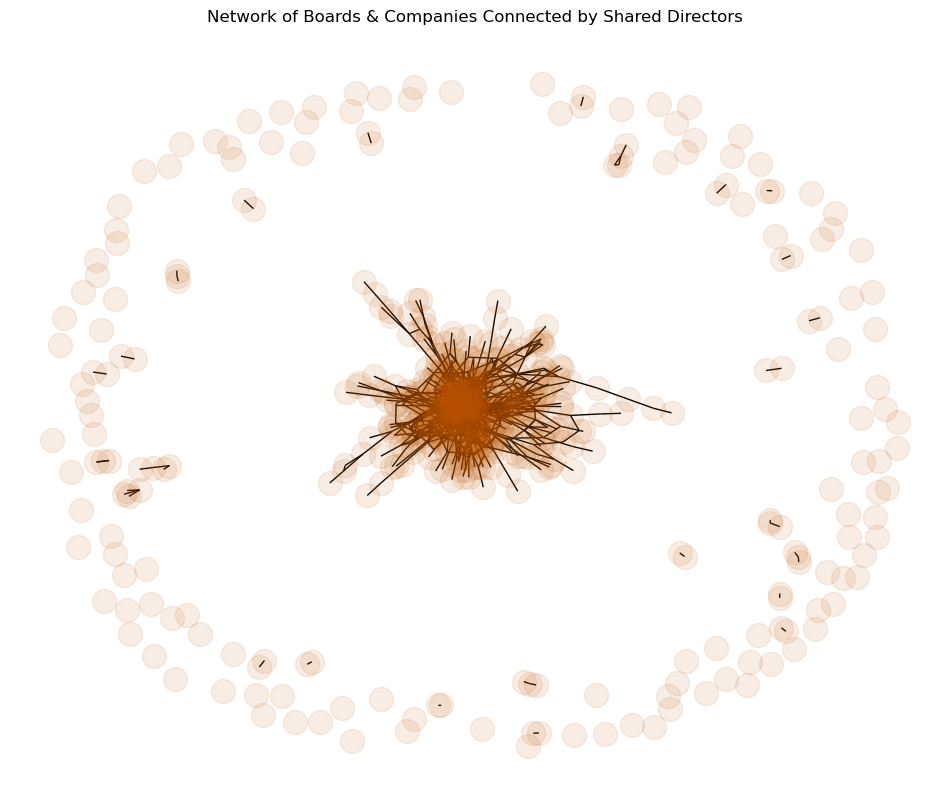

Number of isolated boards (no shared directors): 124
Example isolated boards: [1327.0, 1562.0, 14282.0, 2596.0, 112158.0, 12568.0, 13480.0, 34376.0, 64637.0, 141277.0]


In [540]:
import matplotlib.pyplot as plt
import networkx as nx

# Generate a layout for our nodes
pos = nx.spring_layout(G, seed=42)

plt.figure(figsize=(12, 10))

# Draw nodes with the specified color (#bf5700) and size
nx.draw_networkx_nodes(G, pos, node_color='#bf5700', node_size=300, alpha=0.1)

# Draw edges as straight lines
nx.draw_networkx_edges(G, pos, edge_color='black', width=1, alpha=1, connectionstyle='arc3, rad=0')

plt.title("Network of Boards & Companies Connected by Shared Directors")
plt.axis('off')
plt.show()

# Check for isolated nodes
isolated_nodes = [node for node in G.nodes if G.degree(node) == 0]
print(f"Number of isolated boards (no shared directors): {len(isolated_nodes)}")
if len(isolated_nodes) > 0:
    print("Example isolated boards:", isolated_nodes[:10])  # Print first 10 isolated nodes




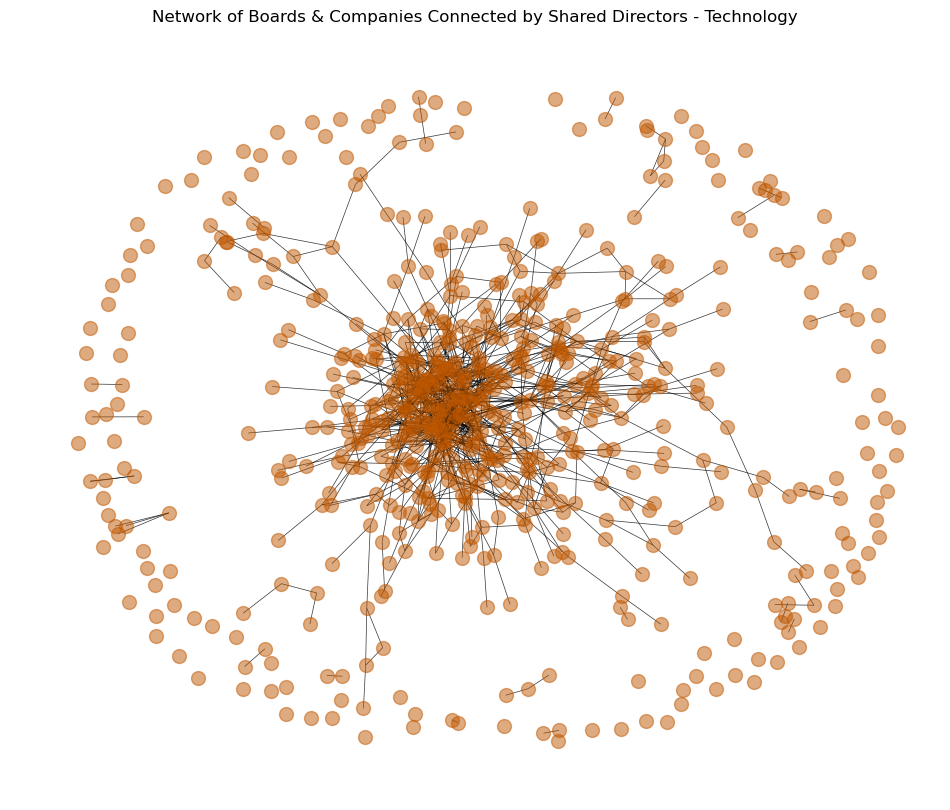

Number of isolated boards (no shared directors): 124
Example isolated boards: [1327.0, 1562.0, 14282.0, 2596.0, 112158.0, 12568.0, 13480.0, 34376.0, 64637.0, 141277.0]


In [541]:
#IMPROVED TECH PLOT


import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations

# 1. Filter to only include rows where industry_board = 'Technology'
df = merged2[merged2['industry_board'] == 'Technology']

# 2. Create an empty undirected graph
G = nx.Graph()

# 3. Add all unique board nodes (only boards)
boards = df['gvkey_board'].unique()
G.add_nodes_from(boards)

# 4. Group by directorid: for each director, get the set of boards they serve on
director_groups = df.groupby('directorid')['gvkey_board'].unique()

# 5. For each director, add edges between every pair of boards they are associated with.
for director, board_array in director_groups.items():
    board_list = list(set(board_array))  # Ensure uniqueness
    if len(board_list) > 1:
        for board1, board2 in combinations(board_list, 2):
            if G.has_edge(board1, board2):
                G[board1][board2]['weight'] += 1
            else:
                G.add_edge(board1, board2, weight=1)

# 6. Identify the top 5 most connected boards
board_centrality = nx.degree_centrality(G)
top_boards = sorted(board_centrality, key=board_centrality.get, reverse=True)[:5]

# Map board IDs to names for labeling
board_id_to_name = dict(zip(merged2['gvkey_board'], merged2['boardname']))
top_board_labels = {node: board_id_to_name.get(node, str(node)) for node in top_boards}

# Generate a layout with better spacing
pos = nx.spring_layout(G, seed=42, k=0.1)  # Adjusted k for better node spacing

plt.figure(figsize=(12, 10))

# Draw all nodes
nx.draw_networkx_nodes(G, pos, node_color='#bf5700', node_size=100, alpha=0.5)

# Highlight top 5 most connected boards
# nx.draw_networkx_nodes(G, pos, nodelist=top_boards, node_color='red', node_size=300, alpha=0.8)

# Draw edges
nx.draw_networkx_edges(G, pos, edge_color='black', width=0.5, alpha=0.8)

# Label only the top 5 boards
# nx.draw_networkx_labels(G, pos, labels=top_board_labels, font_size=8, font_color='black', font_weight='bold')

# Create legend manually
# from matplotlib.patches import Patch
# legend_elements = [
#     Patch(facecolor='#bf5700', edgecolor='black', label="Other Boards"),
#     Patch(facecolor='red', edgecolor='black', label="Top 5 Most Connected Boards")
# ]

# plt.legend(handles=legend_elements, loc="upper right")
plt.title("Network of Boards & Companies Connected by Shared Directors - Technology")
plt.axis('off')
plt.show()

# Export to Gephi
nx.write_gexf(G, "tech_network.gexf")

# Check for isolated nodes
isolated_nodes = [node for node in G.nodes if G.degree(node) == 0]
print(f"Number of isolated boards (no shared directors): {len(isolated_nodes)}")
if len(isolated_nodes) > 0:
    print("Example isolated boards:", isolated_nodes[:10])  # Print first 10 isolated nodes





In [542]:
import pandas as pd
import networkx as nx

#board_size = merged2.groupby('boardname')['directorname'].nunique()

# Compute centrality measures
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
closeness_centrality = nx.closeness_centrality(G)

#Normalize Degree Centrality by board size
# normalized_degree_centrality = {board: degree_centrality[board] / board_size[board] if board in board_size else 0 
#                                 for board in degree_centrality}

# normalized_betweeness_centrality = {board: betweenness_centrality[board] / board_size[board] if board in board_size else 0 
#                                 for board in degree_centrality}

# normalized_closeness_centrality = {board: closeness_centrality[board] / board_size[board] if board in board_size else 0 
#                                 for board in degree_centrality}

# Create a mapping from gvkey_board to boardname (assuming both exist in merged2)
board_name_mapping = dict(zip(merged2['gvkey_board'], merged2['boardname']))

# Convert to a DataFrame for better readability
centrality_df = pd.DataFrame({
    'Board ID': list(degree_centrality.keys()),  # gvkey_board values
    'Board Name': [board_name_mapping.get(board, 'Unknown') for board in degree_centrality.keys()],  # Map to boardname
    'Degree Centrality': list(degree_centrality.values()),
    'Betweenness Centrality': list(betweenness_centrality.values()),
    'Closeness Centrality': list(closeness_centrality.values())
})

In [543]:
centrality_df['Centrality Sum'] = centrality_df['Betweenness Centrality'] + centrality_df['Degree Centrality'] + centrality_df['Closeness Centrality']
centrality_df = centrality_df.sort_values(by="Centrality Sum", ascending=False)
centrality_df.head(5)

,Board ID,Board Name,Degree Centrality,Betweenness Centrality,Closeness Centrality,Centrality Sum
176,160329.0,ALPHABET INC (Google Inc prior to 10/2015),0.047154,0.071149,0.235804,0.354107
94,12141.0,MICROSOFT CORP,0.040650,0.060280,0.233243,0.334174
34,20779.0,CISCO SYSTEMS INC,0.039024,0.047878,0.230914,0.317817
69,6008.0,INTEL CORP,0.040650,0.059029,0.215829,0.315509
173,157855.0,SALESFORCE INC (Salesforce.com Inc prior to 04...,0.035772,0.039294,0.218021,0.293086


### Financial Services

In [545]:

# 1. Filter to only include rows where industry_board = 'Technology'
df = merged2[merged2['industry_board'] == 'Financial']

# 2. Create an empty undirected graph
G = nx.Graph()

# 3. Add all unique board nodes (only boards)
boards = df['gvkey_board'].unique()
G.add_nodes_from(boards)

# 4. Group by directorid: for each director, get the set of boards they serve on
director_groups = df.groupby('directorid')['gvkey_board'].unique()

# 5. For each director, add edges between every pair of boards they are associated with.
for director, board_array in director_groups.items():
    board_list = list(set(board_array))  # Ensure uniqueness
    if len(board_list) > 1:
        # If a director serves on more than one board, connect every pair
        for board1, board2 in combinations(board_list, 2):
            if G.has_edge(board1, board2):
                G[board1][board2]['weight'] += 1
            else:
                G.add_edge(board1, board2, weight=1)
    # Do nothing if a director is associated with only one board (no self-loop)

# 6. Print summary information
print("Number of board nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())

# Optional: Print each edge with its weight
for u, v, data in G.edges(data=True):
    print(f"{u} -- {v} (shared directors: {data['weight']})")


Number of board nodes: 724
Number of edges: 872
16821.0 -- 32698.0 (shared directors: 1)
4690.0 -- 259518.0 (shared directors: 1)
136265.0 -- 158587.0 (shared directors: 2)
136265.0 -- 175607.0 (shared directors: 1)
136265.0 -- 18619.0 (shared directors: 1)
136265.0 -- 39909.0 (shared directors: 1)
136265.0 -- 15633.0 (shared directors: 1)
21593.0 -- 5786.0 (shared directors: 1)
17195.0 -- 12603.0 (shared directors: 1)
29101.0 -- 1417.0 (shared directors: 1)
29101.0 -- 64794.0 (shared directors: 1)
30384.0 -- 63781.0 (shared directors: 1)
16845.0 -- 162293.0 (shared directors: 1)
16845.0 -- 13342.0 (shared directors: 1)
28866.0 -- 31774.0 (shared directors: 1)
4737.0 -- 24620.0 (shared directors: 1)
4737.0 -- 20299.0 (shared directors: 1)
4737.0 -- 145552.0 (shared directors: 1)
4640.0 -- 2968.0 (shared directors: 1)
1076.0 -- 158587.0 (shared directors: 1)
1076.0 -- 24750.0 (shared directors: 1)
28323.0 -- 31994.0 (shared directors: 1)
28323.0 -- 183780.0 (shared directors: 1)
28034.0

/var/folders/8y/vqcryym131n1m9tyx588x_nc0000gn/T/ipykernel_72763/174467622.py:13: UserWarning: 

The connectionstyle keyword argument is not applicable when drawing edges
with LineCollection.

To make this warning go away, either specify `arrows=True` to
force FancyArrowPatches or use the default value for connectionstyle.
Note that using FancyArrowPatches may be slow for large graphs.

  nx.draw_networkx_edges(G, pos, edge_color='black', width=1, alpha=1, connectionstyle='arc3, rad=0')


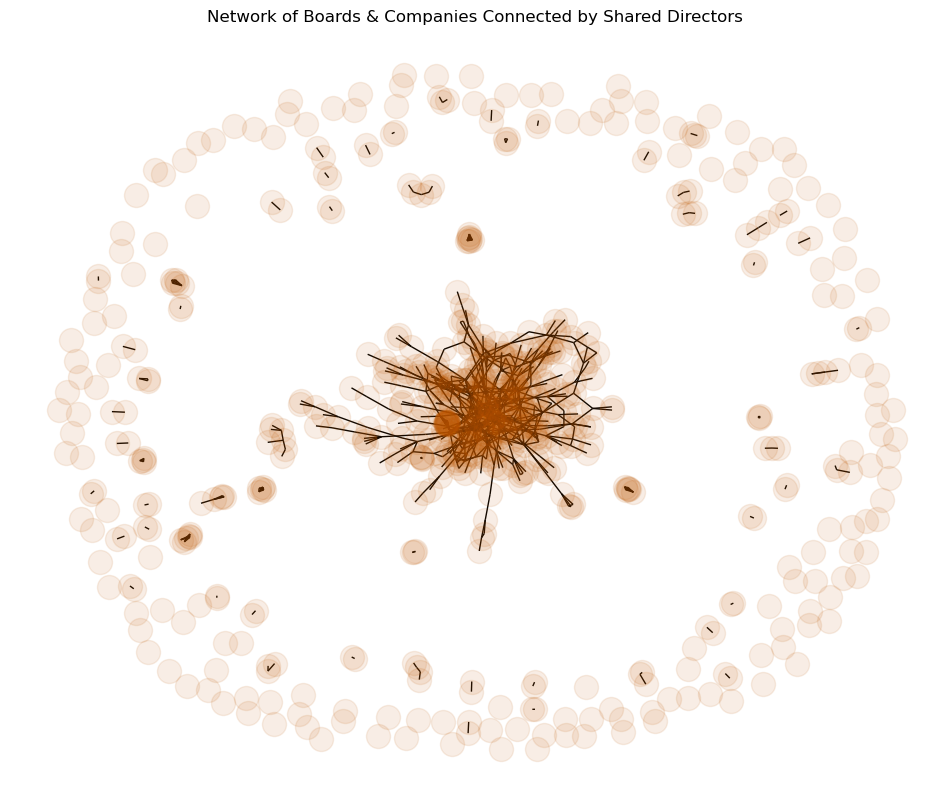

Number of isolated boards (no shared directors): 163
Example isolated boards: [18307.0, 15199.0, 30222.0, 61004.0, 8431.0, 16671.0, 61487.0, 24447.0, 13562.0, 20029.0]


In [546]:
import matplotlib.pyplot as plt
import networkx as nx

# Generate a layout for our nodes
pos = nx.spring_layout(G, seed=42)

plt.figure(figsize=(12, 10))

# Draw nodes with the specified color (#bf5700) and size
nx.draw_networkx_nodes(G, pos, node_color='#bf5700', node_size=300, alpha=0.1)

# Draw edges as straight lines
nx.draw_networkx_edges(G, pos, edge_color='black', width=1, alpha=1, connectionstyle='arc3, rad=0')

plt.title("Network of Boards & Companies Connected by Shared Directors")
plt.axis('off')
plt.show()

# Check for isolated nodes
isolated_nodes = [node for node in G.nodes if G.degree(node) == 0]
print(f"Number of isolated boards (no shared directors): {len(isolated_nodes)}")
if len(isolated_nodes) > 0:
    print("Example isolated boards:", isolated_nodes[:10])  # Print first 10 isolated nodes


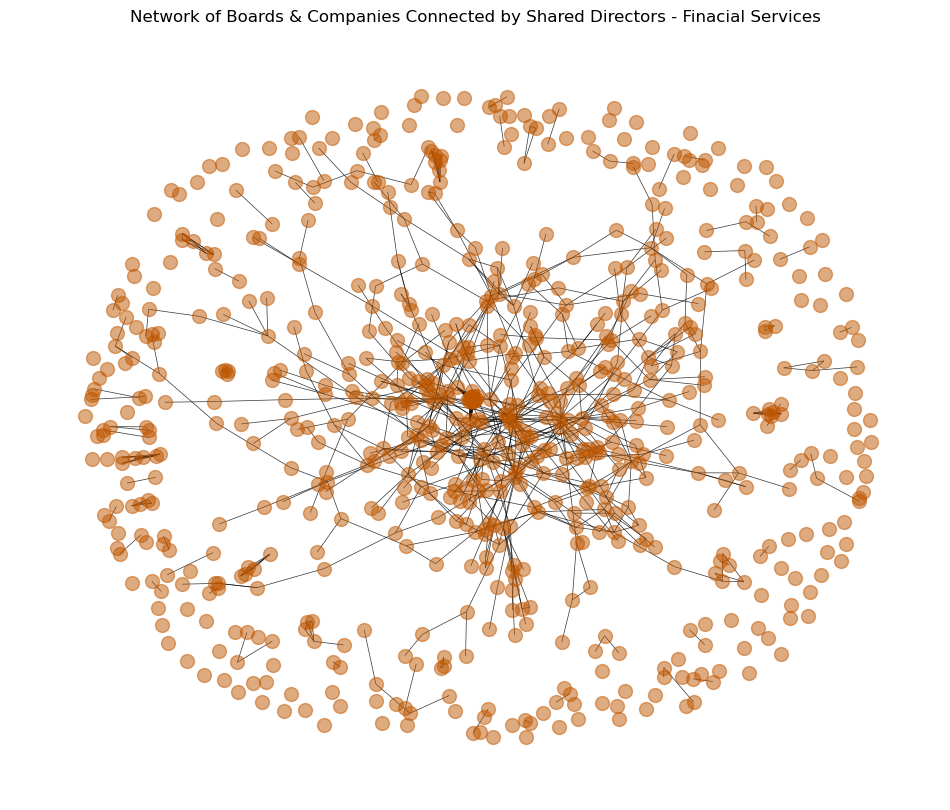

Number of isolated boards (no shared directors): 163
Example isolated boards: [18307.0, 15199.0, 30222.0, 61004.0, 8431.0, 16671.0, 61487.0, 24447.0, 13562.0, 20029.0]


In [547]:
#IMPROVED FINANCE PLOT

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations

# 1. Filter to only include rows where industry_board = 'Technology'
df = merged2[merged2['industry_board'] == 'Financial']

# 2. Create an empty undirected graph
G = nx.Graph()

# 3. Add all unique board nodes (only boards)
boards = df['gvkey_board'].unique()
G.add_nodes_from(boards)

# 4. Group by directorid: for each director, get the set of boards they serve on
director_groups = df.groupby('directorid')['gvkey_board'].unique()

# 5. For each director, add edges between every pair of boards they are associated with.
for director, board_array in director_groups.items():
    board_list = list(set(board_array))  # Ensure uniqueness
    if len(board_list) > 1:
        for board1, board2 in combinations(board_list, 2):
            if G.has_edge(board1, board2):
                G[board1][board2]['weight'] += 1
            else:
                G.add_edge(board1, board2, weight=1)

# 6. Identify the top 5 most connected boards
board_centrality = nx.degree_centrality(G)
top_boards = sorted(board_centrality, key=board_centrality.get, reverse=True)[:5]

# Map board IDs to names for labeling
board_id_to_name = dict(zip(merged2['gvkey_board'], merged2['boardname']))
top_board_labels = {node: board_id_to_name.get(node, str(node)) for node in top_boards}

# Generate a layout with better spacing
pos = nx.spring_layout(G, seed=42, k=0.1)  # Adjusted k for better node spacing

plt.figure(figsize=(12, 10))

# Draw all nodes
nx.draw_networkx_nodes(G, pos, node_color='#bf5700', node_size=100, alpha=0.5)

# Highlight top 5 most connected boards
# nx.draw_networkx_nodes(G, pos, nodelist=top_boards, node_color='red', node_size=300, alpha=0.8)

# Draw edges
nx.draw_networkx_edges(G, pos, edge_color='black', width=0.5, alpha=0.8)

# Label only the top 5 boards
# nx.draw_networkx_labels(G, pos, labels=top_board_labels, font_size=8, font_color='black', font_weight='bold')

# Create legend manually
# from matplotlib.patches import Patch
# legend_elements = [
#     Patch(facecolor='#bf5700', edgecolor='black', label="Other Boards"),
#     Patch(facecolor='red', edgecolor='black', label="Top 5 Most Connected Boards")
# ]

# plt.legend(handles=legend_elements, loc="upper right")
plt.title("Network of Boards & Companies Connected by Shared Directors - Finacial Services")
plt.axis('off')
plt.show()

# Export to Gephi
nx.write_gexf(G, "tech_network.gexf")

# Check for isolated nodes
isolated_nodes = [node for node in G.nodes if G.degree(node) == 0]
print(f"Number of isolated boards (no shared directors): {len(isolated_nodes)}")
if len(isolated_nodes) > 0:
    print("Example isolated boards:", isolated_nodes[:10])  # Print first 10 isolated nodes




In [548]:
import pandas as pd
import networkx as nx

# Compute centrality measures
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
closeness_centrality = nx.closeness_centrality(G)

# Create a mapping from gvkey_board to boardname (assuming both exist in merged2)
board_name_mapping = dict(zip(merged2['gvkey_board'], merged2['boardname']))

# Convert to a DataFrame for better readability
centrality_df = pd.DataFrame({
    'Board ID': list(degree_centrality.keys()),  # gvkey_board values
    'Board Name': [board_name_mapping.get(board, 'Unknown') for board in degree_centrality.keys()],  # Map to boardname
    'Degree Centrality': list(degree_centrality.values()),
    'Betweenness Centrality': list(betweenness_centrality.values()),
    'Closeness Centrality': list(closeness_centrality.values())
})

In [549]:
centrality_df['Centrality Sum'] = centrality_df['Betweenness Centrality'] + centrality_df['Degree Centrality'] + centrality_df['Closeness Centrality']
centrality_df = centrality_df.sort_values(by="Degree Centrality", ascending=False)
centrality_df.head(5)

,Board ID,Board Name,Degree Centrality,Betweenness Centrality,Closeness Centrality,Centrality Sum
158,2968.0,JPMORGAN CHASE & CO,0.023513,0.059749,0.142529,0.225791
204,26104.0,NUVEEN SELECT MATURITIES MUNICIPAL FUND,0.023513,0.000320,0.096991,0.120824
422,151572.0,NUVEEN CALIFORNIA AMT-FREE QUALITY MUNICIPAL I...,0.023513,0.000320,0.096991,0.120824
423,151574.0,NUVEEN NEW YORK AMT-FREE QUALITY MUNICIPAL INC...,0.023513,0.000320,0.096991,0.120824
416,157418.0,NUVEEN MUNICIPAL HIGH INCOME OPPORTUNITY FUND,0.023513,0.000320,0.096991,0.120824


### Oil & Gas

In [551]:

# 1. Filter to only include rows where industry_board = 'Technology'
df = merged2[merged2['industry_board'] == 'Oil & Gas']

# 2. Create an empty undirected graph
G = nx.Graph()

# 3. Add all unique board nodes (only boards)
boards = df['gvkey_board'].unique()
G.add_nodes_from(boards)

# 4. Group by directorid: for each director, get the set of boards they serve on
director_groups = df.groupby('directorid')['gvkey_board'].unique()

# 5. For each director, add edges between every pair of boards they are associated with.
for director, board_array in director_groups.items():
    board_list = list(set(board_array))  # Ensure uniqueness
    if len(board_list) > 1:
        # If a director serves on more than one board, connect every pair
        for board1, board2 in combinations(board_list, 2):
            if G.has_edge(board1, board2):
                G[board1][board2]['weight'] += 1
            else:
                G.add_edge(board1, board2, weight=1)
    # Do nothing if a director is associated with only one board (no self-loop)

# 6. Print summary information
print("Number of board nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())

# Optional: Print each edge with its weight
for u, v, data in G.edges(data=True):
    print(f"{u} -- {v} (shared directors: {data['weight']})")


Number of board nodes: 142
Number of edges: 111
1380.0 -- 21833.0 (shared directors: 1)
1678.0 -- 65006.0 (shared directors: 1)
1678.0 -- 29108.0 (shared directors: 1)
1678.0 -- 13431.0 (shared directors: 1)
32106.0 -- 8549.0 (shared directors: 1)
29135.0 -- 187698.0 (shared directors: 2)
29135.0 -- 21431.0 (shared directors: 1)
29135.0 -- 29108.0 (shared directors: 1)
29135.0 -- 27199.0 (shared directors: 1)
29135.0 -- 194755.0 (shared directors: 1)
2259.0 -- 10221.0 (shared directors: 1)
20548.0 -- 206243.0 (shared directors: 1)
20548.0 -- 162894.0 (shared directors: 1)
65006.0 -- 38800.0 (shared directors: 1)
65006.0 -- 178674.0 (shared directors: 1)
65006.0 -- 29108.0 (shared directors: 1)
15060.0 -- 145812.0 (shared directors: 1)
15060.0 -- 194755.0 (shared directors: 1)
15060.0 -- 26069.0 (shared directors: 1)
29453.0 -- 8068.0 (shared directors: 1)
29453.0 -- 4430.0 (shared directors: 1)
29453.0 -- 9890.0 (shared directors: 1)
2991.0 -- 8272.0 (shared directors: 1)
2991.0 -- 187

/var/folders/8y/vqcryym131n1m9tyx588x_nc0000gn/T/ipykernel_72763/174467622.py:13: UserWarning: 

The connectionstyle keyword argument is not applicable when drawing edges
with LineCollection.

To make this warning go away, either specify `arrows=True` to
force FancyArrowPatches or use the default value for connectionstyle.
Note that using FancyArrowPatches may be slow for large graphs.

  nx.draw_networkx_edges(G, pos, edge_color='black', width=1, alpha=1, connectionstyle='arc3, rad=0')


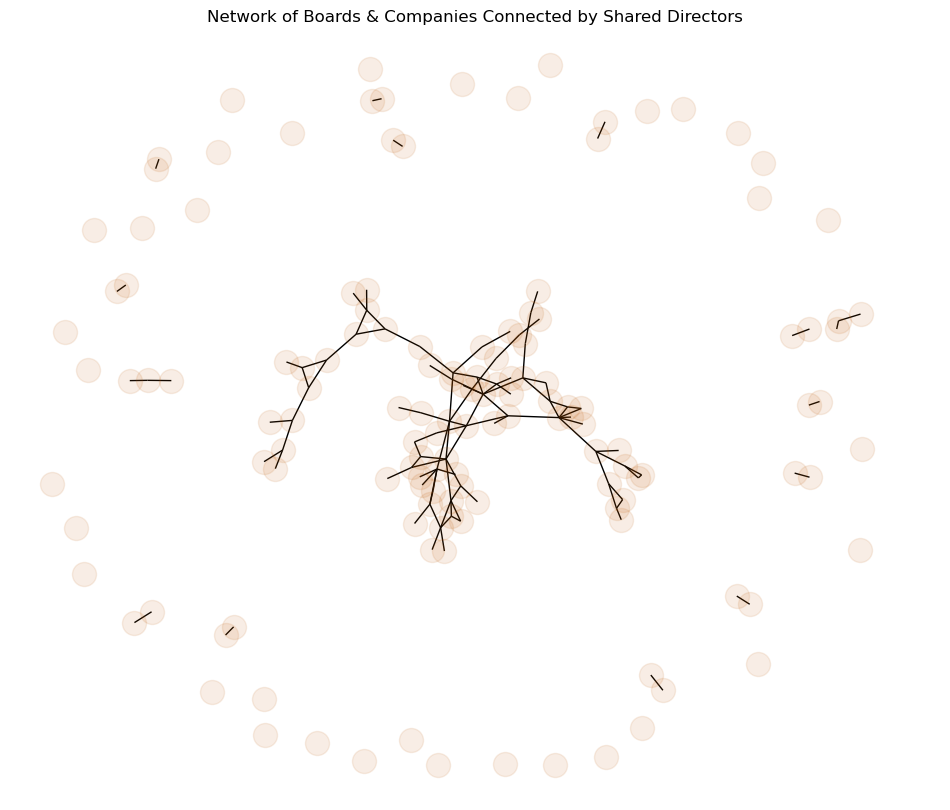

Number of isolated boards (no shared directors): 35
Example isolated boards: [2052.0, 2771.0, 15055.0, 2986.0, 120093.0, 64063.0, 5439.0, 7620.0, 1661.0, 8079.0]


In [552]:
import matplotlib.pyplot as plt
import networkx as nx

# Generate a layout for our nodes
pos = nx.spring_layout(G, seed=42)

plt.figure(figsize=(12, 10))

# Draw nodes with the specified color (#bf5700) and size
nx.draw_networkx_nodes(G, pos, node_color='#bf5700', node_size=300, alpha=0.1)

# Draw edges as straight lines
nx.draw_networkx_edges(G, pos, edge_color='black', width=1, alpha=1, connectionstyle='arc3, rad=0')

plt.title("Network of Boards & Companies Connected by Shared Directors")
plt.axis('off')
plt.show()

# Check for isolated nodes
isolated_nodes = [node for node in G.nodes if G.degree(node) == 0]
print(f"Number of isolated boards (no shared directors): {len(isolated_nodes)}")
if len(isolated_nodes) > 0:
    print("Example isolated boards:", isolated_nodes[:10])  # Print first 10 isolated nodes


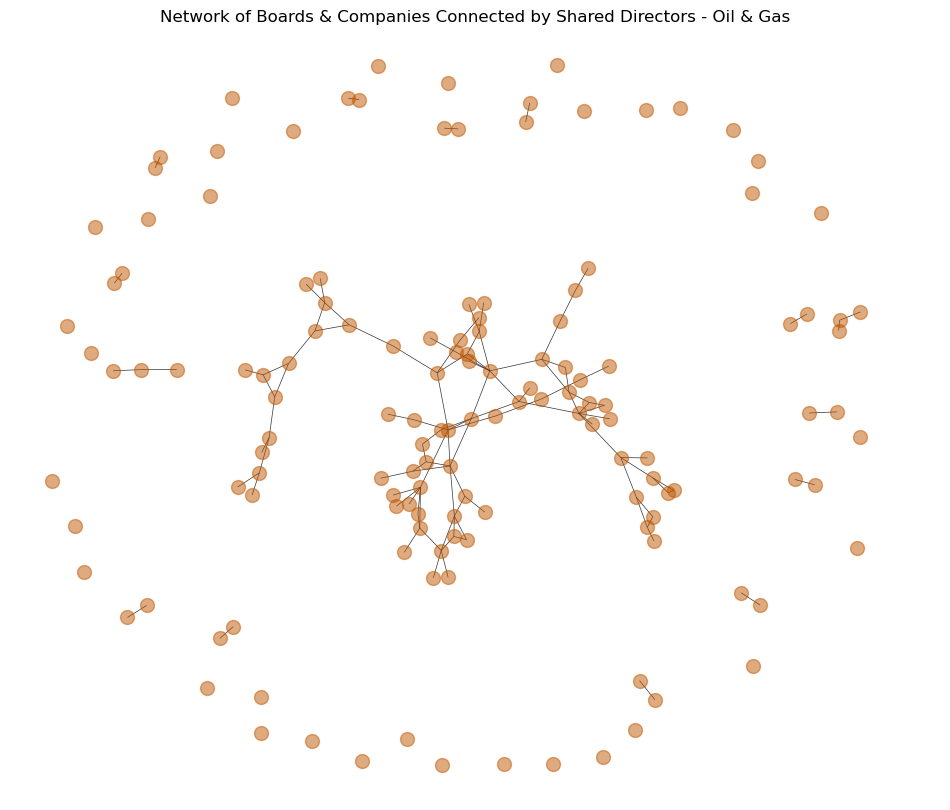

Number of isolated boards (no shared directors): 35
Example isolated boards: [2052.0, 2771.0, 15055.0, 2986.0, 120093.0, 64063.0, 5439.0, 7620.0, 1661.0, 8079.0]


In [553]:
# IMPROVED ENERGY PLOT

#IMPROVED FINANCE PLOT

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations

# 1. Filter to only include rows where industry_board = 'Technology'
df = merged2[merged2['industry_board'] == 'Oil & Gas']

# 2. Create an empty undirected graph
G = nx.Graph()

# 3. Add all unique board nodes (only boards)
boards = df['gvkey_board'].unique()
G.add_nodes_from(boards)

# 4. Group by directorid: for each director, get the set of boards they serve on
director_groups = df.groupby('directorid')['gvkey_board'].unique()

# 5. For each director, add edges between every pair of boards they are associated with.
for director, board_array in director_groups.items():
    board_list = list(set(board_array))  # Ensure uniqueness
    if len(board_list) > 1:
        for board1, board2 in combinations(board_list, 2):
            if G.has_edge(board1, board2):
                G[board1][board2]['weight'] += 1
            else:
                G.add_edge(board1, board2, weight=1)

# 6. Identify the top 5 most connected boards
board_centrality = nx.degree_centrality(G)
top_boards = sorted(board_centrality, key=board_centrality.get, reverse=True)[:5]

# Map board IDs to names for labeling
board_id_to_name = dict(zip(merged2['gvkey_board'], merged2['boardname']))
top_board_labels = {node: board_id_to_name.get(node, str(node)) for node in top_boards}

# Generate a layout with better spacing
pos = nx.spring_layout(G, seed=42, k=0.1)  # Adjusted k for better node spacing

plt.figure(figsize=(12, 10))

# Draw all nodes
nx.draw_networkx_nodes(G, pos, node_color='#bf5700', node_size=100, alpha=0.5)

# Highlight top 5 most connected boards
# nx.draw_networkx_nodes(G, pos, nodelist=top_boards, node_color='red', node_size=300, alpha=0.8)

# Draw edges
nx.draw_networkx_edges(G, pos, edge_color='black', width=0.5, alpha=0.8)

# Label only the top 5 boards
# nx.draw_networkx_labels(G, pos, labels=top_board_labels, font_size=8, font_color='black', font_weight='bold')

# Create legend manually
# from matplotlib.patches import Patch
# legend_elements = [
#     Patch(facecolor='#bf5700', edgecolor='black', label="Other Boards"),
#     Patch(facecolor='red', edgecolor='black', label="Top 5 Most Connected Boards")
# ]

# plt.legend(handles=legend_elements, loc="upper right")
plt.title("Network of Boards & Companies Connected by Shared Directors - Oil & Gas")
plt.axis('off')
plt.show()

# Export to Gephi
nx.write_gexf(G, "tech_network.gexf")

# Check for isolated nodes
isolated_nodes = [node for node in G.nodes if G.degree(node) == 0]
print(f"Number of isolated boards (no shared directors): {len(isolated_nodes)}")
if len(isolated_nodes) > 0:
    print("Example isolated boards:", isolated_nodes[:10])  # Print first 10 isolated nodes




In [554]:
import pandas as pd
import networkx as nx

# Compute centrality measures
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
closeness_centrality = nx.closeness_centrality(G)

# Create a mapping from gvkey_board to boardname (assuming both exist in merged2)
board_name_mapping = dict(zip(merged2['gvkey_board'], merged2['boardname']))

# Convert to a DataFrame for better readability
centrality_df = pd.DataFrame({
    'Board ID': list(degree_centrality.keys()),  # gvkey_board values
    'Board Name': [board_name_mapping.get(board, 'Unknown') for board in degree_centrality.keys()],  # Map to boardname
    'Degree Centrality': list(degree_centrality.values()),
    'Betweenness Centrality': list(betweenness_centrality.values()),
    'Closeness Centrality': list(closeness_centrality.values())
})

In [555]:
centrality_df['Centrality Sum'] = centrality_df['Betweenness Centrality'] + centrality_df['Degree Centrality'] + centrality_df['Closeness Centrality']
centrality_df = centrality_df.sort_values(by="Centrality Sum", ascending=False)
centrality_df.head(5)

,Board ID,Board Name,Degree Centrality,Betweenness Centrality,Closeness Centrality,Centrality Sum
83,187698.0,CIVITAS RESOURCES INC (Bonanza Creek Energy In...,0.042553,0.125447,0.144241,0.312242
4,29135.0,BAYTEX ENERGY CORP (Formerly known as Baytex E...,0.035461,0.101030,0.144241,0.280732
120,13431.0,BERRY CORP (Berry Petroleum Corp prior to 02/2...,0.028369,0.108865,0.133435,0.270669
36,29108.0,PATTERSON UTI ENERGY INC,0.049645,0.081763,0.137005,0.268413
75,184442.0,CHORD ENERGY CORP (Oasis Petroleum Inc prior t...,0.049645,0.086981,0.115393,0.252019


### Cross Industry

In [557]:

# 1. Filter to only include rows where industry_board = 'Technology'
df = merged2

# 2. Create an empty undirected graph
G = nx.Graph()

# 3. Add all unique board nodes (only boards)
boards = df['gvkey_board'].unique()
G.add_nodes_from(boards)

# 4. Group by directorid: for each director, get the set of boards they serve on
director_groups = df.groupby('directorid')['gvkey_board'].unique()

# 5. For each director, add edges between every pair of boards they are associated with.
for director, board_array in director_groups.items():
    board_list = list(set(board_array))  # Ensure uniqueness
    if len(board_list) > 1:
        # If a director serves on more than one board, connect every pair
        for board1, board2 in combinations(board_list, 2):
            if G.has_edge(board1, board2):
                G[board1][board2]['weight'] += 1
            else:
                G.add_edge(board1, board2, weight=1)
    # Do nothing if a director is associated with only one board (no self-loop)

# 6. Print summary information
print("Number of board nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())

# Optional: Print each edge with its weight
for u, v, data in G.edges(data=True):
    print(f"{u} -- {v} (shared directors: {data['weight']})")


Number of board nodes: 4097
Number of edges: 14466
122519.0 -- 184717.0 (shared directors: 1)
122519.0 -- 6066.0 (shared directors: 2)
16821.0 -- 32698.0 (shared directors: 1)
24157.0 -- 22439.0 (shared directors: 1)
4690.0 -- 38022.0 (shared directors: 1)
4690.0 -- 23208.0 (shared directors: 1)
4690.0 -- 38592.0 (shared directors: 1)
4690.0 -- 165993.0 (shared directors: 1)
4690.0 -- 4094.0 (shared directors: 1)
4690.0 -- 259518.0 (shared directors: 1)
136265.0 -- 158587.0 (shared directors: 2)
136265.0 -- 175607.0 (shared directors: 1)
136265.0 -- 18619.0 (shared directors: 1)
136265.0 -- 39909.0 (shared directors: 1)
136265.0 -- 15633.0 (shared directors: 1)
21593.0 -- 7085.0 (shared directors: 1)
21593.0 -- 5786.0 (shared directors: 1)
17195.0 -- 12603.0 (shared directors: 1)
17195.0 -- 4941.0 (shared directors: 1)
17195.0 -- 13602.0 (shared directors: 1)
17195.0 -- 12441.0 (shared directors: 1)
29101.0 -- 1417.0 (shared directors: 1)
29101.0 -- 64302.0 (shared directors: 1)
29101.

In [558]:
centrality_df['Centrality Sum'] = centrality_df['Betweenness Centrality'] + centrality_df['Degree Centrality'] + centrality_df['Closeness Centrality']
centrality_df = centrality_df.sort_values(by="Centrality Sum", ascending=False)
centrality_df.head(5)

,Board ID,Board Name,Degree Centrality,Betweenness Centrality,Closeness Centrality,Centrality Sum
83,187698.0,CIVITAS RESOURCES INC (Bonanza Creek Energy In...,0.042553,0.125447,0.144241,0.312242
4,29135.0,BAYTEX ENERGY CORP (Formerly known as Baytex E...,0.035461,0.101030,0.144241,0.280732
120,13431.0,BERRY CORP (Berry Petroleum Corp prior to 02/2...,0.028369,0.108865,0.133435,0.270669
36,29108.0,PATTERSON UTI ENERGY INC,0.049645,0.081763,0.137005,0.268413
75,184442.0,CHORD ENERGY CORP (Oasis Petroleum Inc prior t...,0.049645,0.086981,0.115393,0.252019


In [559]:
board_director_count = merged2.groupby('boardname')['directorname'].count()
board_director_count = board_director_count.sort_values(ascending=False)
board_director_count.head(5)

boardname
LIBERTY MEDIA CORP                                                                                                              900
BROOKFIELD CORP (Brookfield Asset Management Inc prior to 12/2022)                                                              464
NUVEEN CALIFORNIA AMT-FREE QUALITY MUNICIPAL INCOME FUND (Nuveen California Amt-Free Municipal Income Fund prior to 12/2016)    377
NUVEEN NEW YORK AMT-FREE QUALITY MUNICIPAL INCOME FUND                                                                          361
BROOKFIELD INFRASTRUCTURE PARTNERS LP                                                                                           336
Name: directorname, dtype: int64

In [560]:
import pandas as pd
import networkx as nx

board_size = merged2.groupby('boardname')['directorname'].nunique()

# Compute centrality measures
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
closeness_centrality = nx.closeness_centrality(G)

# Normalize Degree Centrality by board size
normalized_degree_centrality = {board: degree_centrality[board] / board_size[board] if board in board_size else 0 
                                for board in degree_centrality}

# Create a mapping from gvkey_board to boardname (assuming both exist in merged2)
board_name_mapping = dict(zip(merged2['gvkey_board'], merged2['boardname']))

# Convert to a DataFrame for better readability
centrality_df = pd.DataFrame({
    'Board ID': list(degree_centrality.keys()),  # gvkey_board values
    'Board Name': [board_name_mapping.get(board, 'Unknown') for board in degree_centrality.keys()],  # Map to boardname
    'Degree Centrality': list(normalized_degree_centrality.values()),
    'Betweenness Centrality': list(betweenness_centrality.values()),
    'Closeness Centrality': list(closeness_centrality.values())
})

In [561]:
centrality_df = centrality_df.sort_values(by="Degree Centrality", ascending=False)
centrality_df.head(50)

,Board ID,Board Name,Degree Centrality,Betweenness Centrality,Closeness Centrality
0,122519.0,1-800-FLOWERS.COM INC,0,0.000112,0.209125
2049,187575.0,TILLYS INC,0,0.000000,0.165423
2723,12035.0,RBB BANCORP,0,0.000052,0.191158
2724,36819.0,KYMERA THERAPEUTICS INC,0,0.000696,0.236861
2725,34034.0,SITIO ROYALTIES CORP (Falcon Minerals Corp pri...,0,0.001174,0.201247
2726,324960.0,5E ADVANCED MATERIALS INC (American Pacific Bo...,0,0.000545,0.192618
2727,32102.0,REDFIN CORP,0,0.000415,0.220683
2728,21807.0,CITIUS PHARMACEUTICALS INC,0,0.001088,0.223388
2729,32321.0,MEDICENNA THERAPEUTICS CORP (A2 ACQUISITION CO...,0,0.000147,0.231619
2730,31774.0,BRIGHTHOUSE FINANCIAL INC,0,0.000452,0.209228


In [562]:
centrality_df['Centrality Sum'] = centrality_df['Betweenness Centrality'] + centrality_df['Degree Centrality'] + centrality_df['Closeness Centrality']
centrality_df = centrality_df.sort_values(by="Centrality Sum", ascending=False)
centrality_df.head(5)

,Board ID,Board Name,Degree Centrality,Betweenness Centrality,Closeness Centrality,Centrality Sum
1424,160329.0,ALPHABET INC (Google Inc prior to 10/2015),0,0.035342,0.294990,0.330332
817,12141.0,MICROSOFT CORP,0,0.032821,0.290513,0.323334
297,20779.0,CISCO SYSTEMS INC,0,0.026255,0.293016,0.319271
2048,189459.0,CARLYLE GROUP INC (THE) (Carlyle Group LP (The...,0,0.026594,0.282017,0.308611
1394,177088.0,BLACKSTONE INC (Blackstone Group Inc (The) pri...,0,0.019557,0.283360,0.302917


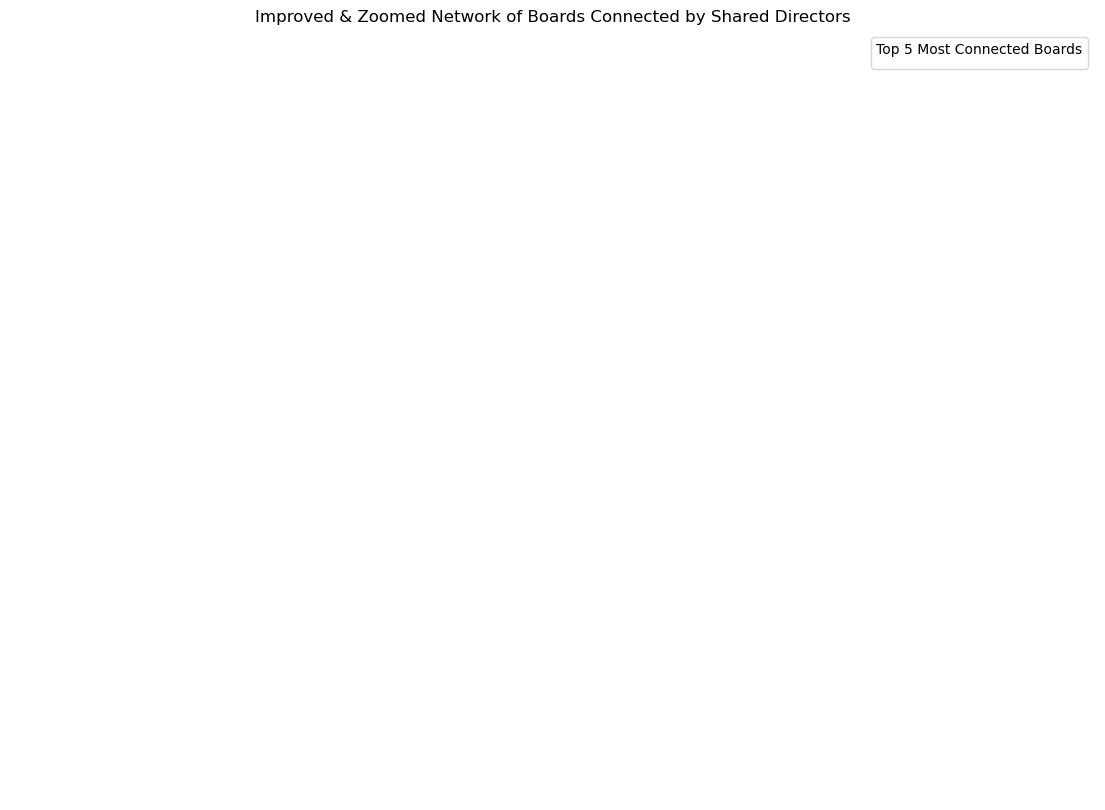

In [563]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# 1. Load and Filter the Data (Adjust industry as needed)
df = merged2[merged2['industry_board'] == 'Financial Services']  # Change for other industries

# 2. Create an Undirected Graph
G = nx.Graph()

# 3. Add Boards as Nodes (Use Names Instead of IDs)
boards = df[['gvkey_board', 'boardname']].drop_duplicates().set_index('gvkey_board')['boardname'].to_dict()
G.add_nodes_from(boards.keys())

# 4. Create Edges Between Boards Based on Shared Directors
director_groups = df.groupby('directorid')['gvkey_board'].unique()

for board_list in director_groups:
    board_list = list(set(board_list))
    if len(board_list) > 1:
        for board1, board2 in combinations(board_list, 2):
            if G.has_edge(board1, board2):
                G[board1][board2]['weight'] += 1
            else:
                G.add_edge(board1, board2, weight=1)

# 5. Compute Centrality Measures
degree_centrality = nx.degree_centrality(G)
top_5_nodes = sorted(degree_centrality, key=degree_centrality.get, reverse=True)[:5]

# 6. Convert Node IDs to Board Names
labels = {node: boards[node] for node in top_5_nodes if node in boards}

# 7. Define Graph Layout
pos = nx.spring_layout(G, seed=42, k=0.2)  # Adjust k for spacing

# 8. Assign Colors (Highlight Top 5)
node_colors = ['red' if node in top_5_nodes else '#bf5700' for node in G.nodes]
node_sizes = [degree_centrality[node] * 3000 for node in G.nodes]

# 9. Draw the Graph
plt.figure(figsize=(14, 10))
nx.draw_networkx_nodes(G, pos, node_color=node_colors, alpha=0.8, node_size=node_sizes)
nx.draw_networkx_edges(G, pos, edge_color='black', width=0.8, alpha=0.9)

# 10. Add Legend with Top 5 Nodes
legend_patches = [mpatches.Patch(color='red', label=f"{boards[node]}") for node in top_5_nodes if node in boards]
plt.legend(handles=legend_patches, loc="upper right", title="Top 5 Most Connected Boards", fontsize=10)

# 11. Final Touches
plt.title("Improved & Zoomed Network of Boards Connected by Shared Directors")
plt.axis('off')
plt.show()


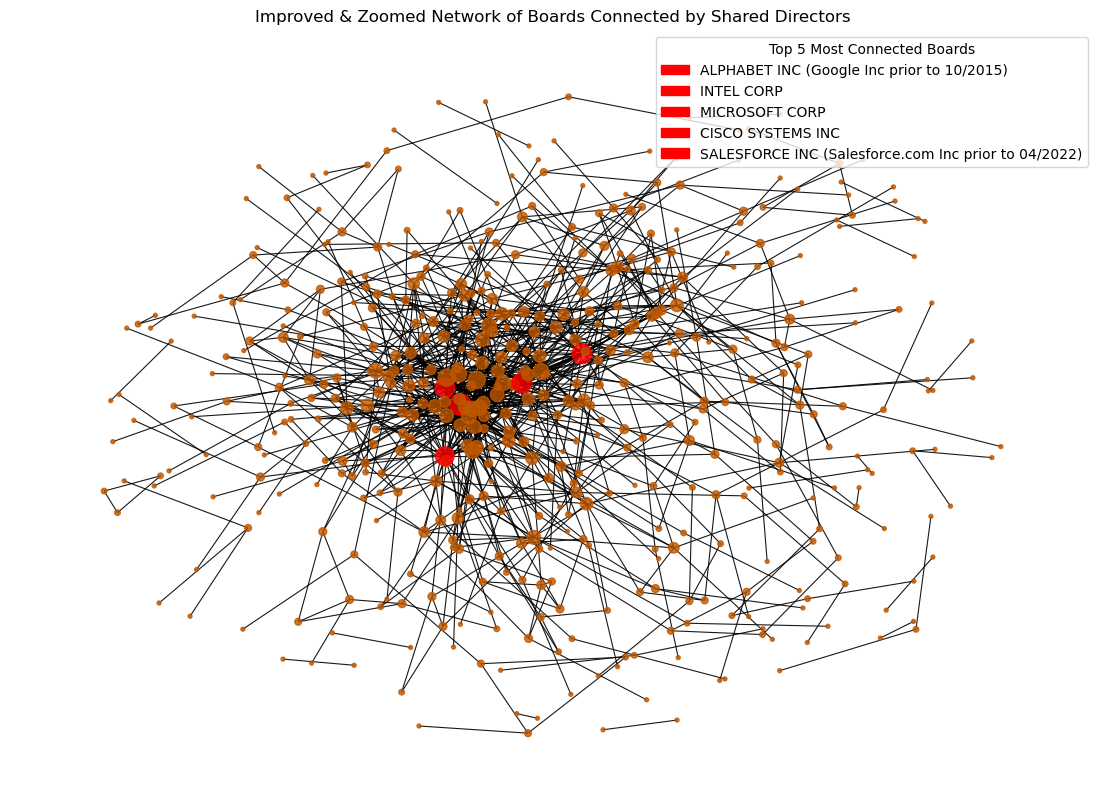

In [564]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# 1. Load and Filter the Data (Adjust industry as needed)
df = merged2[merged2['industry_board'] == 'Technology']  # Change for other industries

# 2. Create an Undirected Graph
G = nx.Graph()

# 3. Add Boards as Nodes (Use Names Instead of IDs)
boards = df[['gvkey_board', 'boardname']].drop_duplicates().set_index('gvkey_board')['boardname'].to_dict()
G.add_nodes_from(boards.keys())

# 4. Create Edges Between Boards Based on Shared Directors
director_groups = df.groupby('directorid')['gvkey_board'].unique()

for board_list in director_groups:
    board_list = list(set(board_list))
    if len(board_list) > 1:
        for board1, board2 in combinations(board_list, 2):
            if G.has_edge(board1, board2):
                G[board1][board2]['weight'] += 1
            else:
                G.add_edge(board1, board2, weight=1)

# 5. Compute Centrality Measures
degree_centrality = nx.degree_centrality(G)
top_5_nodes = sorted(degree_centrality, key=degree_centrality.get, reverse=True)[:5]

# 6. Convert Node IDs to Board Names
labels = {node: boards[node] for node in top_5_nodes if node in boards}

# 7. Define Graph Layout
pos = nx.spring_layout(G, seed=42, k=0.2)  # Adjust k for spacing

# 8. Assign Colors (Highlight Top 5)
node_colors = ['red' if node in top_5_nodes else '#bf5700' for node in G.nodes]
node_sizes = [degree_centrality[node] * 5000 for node in G.nodes]

# 9. Draw the Graph
plt.figure(figsize=(14, 10))
nx.draw_networkx_nodes(G, pos, node_color=node_colors, alpha=0.8, node_size=node_sizes)
nx.draw_networkx_edges(G, pos, edge_color='black', width=0.8, alpha=0.9)

# 10. Add Legend with Top 5 Nodes
legend_patches = [mpatches.Patch(color='red', label=f"{boards[node]}") for node in top_5_nodes if node in boards]
plt.legend(handles=legend_patches, loc="upper right", title="Top 5 Most Connected Boards", fontsize=10)

# 11. Final Touches
plt.title("Improved & Zoomed Network of Boards Connected by Shared Directors")
plt.axis('off')
plt.show()


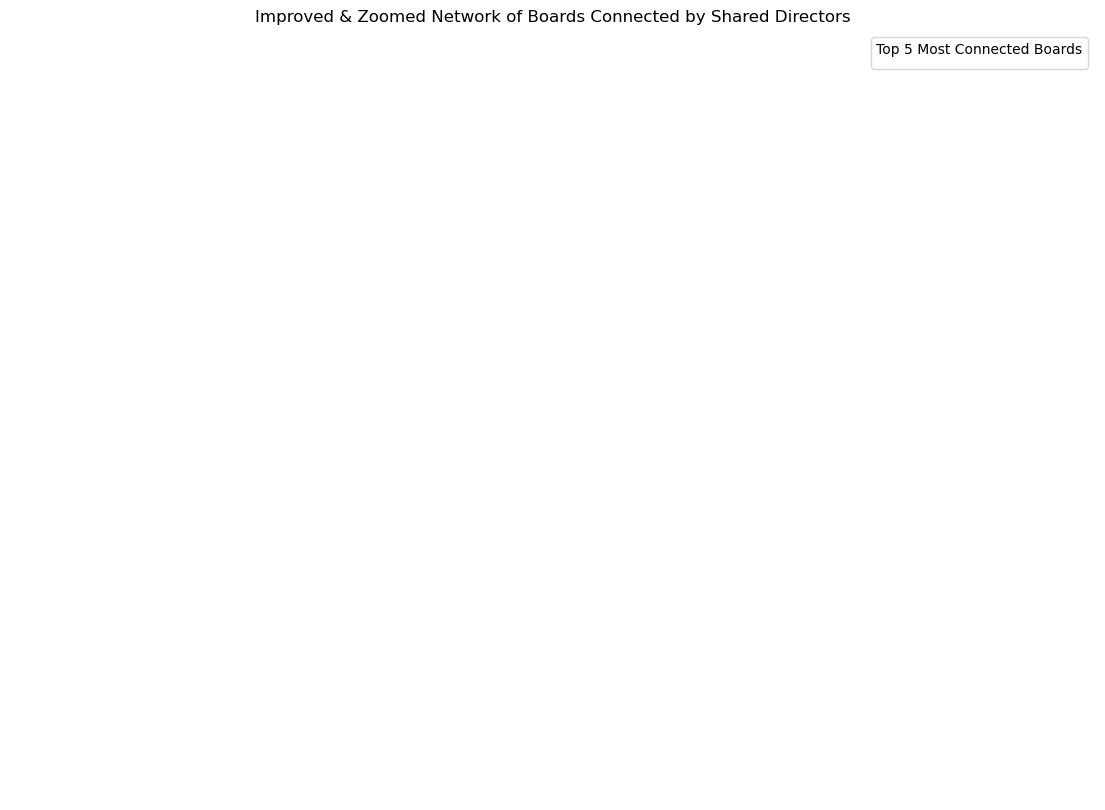

In [565]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# 1. Load and Filter the Data (Adjust industry as needed)
df = merged2[merged2['industry_board'] == 'Energy']  # Change for other industries

# 2. Create an Undirected Graph
G = nx.Graph()

# 3. Add Boards as Nodes (Use Names Instead of IDs)
boards = df[['gvkey_board', 'boardname']].drop_duplicates().set_index('gvkey_board')['boardname'].to_dict()
G.add_nodes_from(boards.keys())

# 4. Create Edges Between Boards Based on Shared Directors
director_groups = df.groupby('directorid')['gvkey_board'].unique()

for board_list in director_groups:
    board_list = list(set(board_list))
    if len(board_list) > 1:
        for board1, board2 in combinations(board_list, 2):
            if G.has_edge(board1, board2):
                G[board1][board2]['weight'] += 1
            else:
                G.add_edge(board1, board2, weight=1)

# 5. Compute Centrality Measures
degree_centrality = nx.degree_centrality(G)
top_5_nodes = sorted(degree_centrality, key=degree_centrality.get, reverse=True)[:5]

# 6. Convert Node IDs to Board Names
labels = {node: boards[node] for node in top_5_nodes if node in boards}

# 7. Define Graph Layout
pos = nx.spring_layout(G, seed=42, k=0.2)  # Adjust k for spacing

# 8. Assign Colors (Highlight Top 5)
node_colors = ['red' if node in top_5_nodes else '#bf5700' for node in G.nodes]
node_sizes = [degree_centrality[node] * 3000 for node in G.nodes]

# 9. Draw the Graph
plt.figure(figsize=(14, 10))
nx.draw_networkx_nodes(G, pos, node_color=node_colors, alpha=0.8, node_size=node_sizes)
nx.draw_networkx_edges(G, pos, edge_color='black', width=0.8, alpha=0.9)

# 10. Add Legend with Top 5 Nodes
legend_patches = [mpatches.Patch(color='red', label=f"{boards[node]}") for node in top_5_nodes if node in boards]
plt.legend(handles=legend_patches, loc="upper right", title="Top 5 Most Connected Boards", fontsize=10)

# 11. Final Touches
plt.title("Improved & Zoomed Network of Boards Connected by Shared Directors")
plt.axis('off')
plt.show()


In [566]:
merged2.groupby("boardname")['companyname'].nunique().sort_values()

boardname
GREEN PLAINS PARTNERS LP (De-listed 01/2024)                          1
ESQUIRE FINANCIAL HOLDINGS INC                                        1
ESSENT GROUP LTD                                                      1
ESSENTIAL PROPERTIES REALTY TRUST INC                                 1
ETHAN ALLEN INTERIORS INC                                             1
                                                                     ..
CARISMA THERAPEUTICS INC (Sesen Bio Inc prior to 03/2023)            45
CARLYLE GROUP INC (THE) (Carlyle Group LP (The) prior to 01/2020)    46
CISCO SYSTEMS INC                                                    50
MICROSOFT CORP                                                       55
ALPHABET INC (Google Inc prior to 10/2015)                           60
Name: companyname, Length: 4099, dtype: int64

In [567]:
import networkx as nx

# Check for isolated nodes in the graph
isolated_nodes = [node for node in G.nodes if G.degree(node) == 0]

# Print the count and some examples
print(f"Number of isolated boards (no shared directors): {len(isolated_nodes)}")
if len(isolated_nodes) > 0:
    print("Example isolated boards:", isolated_nodes[:10])  # Print first 10 isolated nodes


Number of isolated boards (no shared directors): 0
